<h1 style="font-family:Corbel Light; color:#97a9fd">Projet 6 : Classifiez automatiquement des biens de consommation </h1>

<h2 style="font-family:Corbel Light; color:#737373"><span style="color:#97a9fd">Étape 3</span> : Classification supervisée d'images</h2>

<h3 style="font-family:Corbel Light; color:#737373">Requirements</h3>

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

import cv2
from time import perf_counter

import hyperopt
from hyperopt import fmin, hp, tpe, Trials
from hyperopt.early_stop import no_progress_loss
from hyperopt.pyll import scope
from hyperopt import STATUS_OK

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.saving import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from plot_keras_history import show_history, plot_history

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from random import randint
from datetime import timedelta
from functools import partial

import toolbox

%matplotlib inline
pd.options.display.float_format = '{:_.2f}'.format

In [132]:
python_version = !python -V
print('python version :', python_version, '\n')
print('pandas version : ', pd.__version__, '\n')
print('numpy version : ', np.__version__, '\n')
print('matplotlib version : ', matplotlib.__version__, '\n')
print('seaborn version : ', sns.__version__, '\n')
print('scikit-learn version : ', sklearn.__version__, '\n')
print('tensorflow version : ', tf.__version__, '\n') 
print('hyperopt version : ', hyperopt.__version__, '\n') 
print('opencv version : ', cv2.__version__, '\n') 

python version : ['Python 3.9.12'] 

pandas version :  1.4.2 

numpy version :  1.23.5 

matplotlib version :  3.7.1 

seaborn version :  0.12.2 

scikit-learn version :  1.2.1 

tensorflow version :  2.12.0 

hyperopt version :  0.2.7 

opencv version :  4.7.0 



**Versions utilisées :**

- python : Python 3.9.12 
- seaborn    :  0.12.2
- matplotlib :  3.7.1 
- numpy  :  1.23.5 
- pandas :  1.4.2
- scikit-learn :  1.2.1
- opencv :  4.7.0
- tensorflow :  2.12.0
- hyperopt :  0.2.7

<h3 style="font-family:Corbel Light; color:#737373">Préparation des données</h3>

In [3]:
img_path = './Flipkart/Images/'
products = pd.read_pickle('products_data_cleaned.pkl')[['_target', 'image']]
products.head()

,_target,image
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg


**CE2 : Vous avez identifié la ou les cibles.**

<h3 style="font-family:Corbel Light; color:#737373">Modèle VGG-16 - sans data augmentation</h3>

**CE1 : Vous avez défini votre stratégie d’élaboration d’un modèle pour répondre à un besoin métier (par exemple : choix de conception d’un modèle ré-utilisation de modèles pré-entraînés.**

Élaborer un nouveau modèle et l'entrainer en entier prendrait trop de temps. 
Pour résoudre notre problème de classification à 7 classes, nous allons commencer par appliquer une stratégie de transfer learning au réseau VGG-16 fourni par Keras et voir si on obtient de bons résultats. Ce dernier a été pré-entrainé sur un sous ensemble de la base d'images ImageNet pour résoudre un problème de classification à 1000 classes.

Notre stratégie consiste donc à : 
- charger le modèle VGG16 pré-entrainé sans les couches fully connected (qui lui permettent de classifier l'image dans une des 1000 classes). 
- ajouter de nouvelles couches fully connected pour classer les images dans une de nos 7 classes d'articles
- entrainer seulement les nouvelles couches ajoutées sur notre collection d'images, sans ré-entrainer les autres couches. 

En effet, ré-entrainer toutes les couches prendrait beaucoup trop de temps. De plus, notre collection d'images étant petite, le modèle risquerait de surapprendre. Le réseau vgg16 tronqué va donc calculer la représentation de nos images à partir des features déjà apprises.

In [5]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg16.layers:
    layer.trainable = False

<h4 style="font-family:Corbel Light; color:#737373">Pré-traitement des images</h4>

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(products['image'], products['_target'],
                                                    train_size=0.8,
                                                    stratify=products['_target'])

In [ ]:
X_train_preprocessed = toolbox.preprocess_img_vgg16(X_train, img_path, (224, 224))
X_train_preprocessed.shape

In [9]:
X_test_preprocessed = toolbox.preprocess_img_vgg16(X_test, img_path, (224, 224))
X_test_preprocessed.shape

(210, 224, 224, 3)

**CE3 : Vous avez réalisé la séparation du jeu de données en jeu d’entraînement, jeu de validation et jeu de test.**

In [10]:
x_train, x_val, y_train, y_val = train_test_split(X_train_preprocessed,
                                                  Y_train,
                                                  stratify=Y_train,
                                                  test_size=0.25,
                                                  random_state=8)
x_train.shape

(630, 224, 224, 3)

**CE4 Vous vous êtes assurés qu'il n’y a pas de fuite d’information entre les deux jeux de données (entraînement, validation et test).**

Pour éviter la fuite d'information : 
- Un premier label encoder est entrainé uniquement sur le jeu d'entrainement en entier, puis appliqué au jeu de test. 
- Un deuxième label encoder est entrainé uniquement sur le jeu d'entrainement réduit, puis appliqué au jeu de validation.

In [11]:
label_encoder1 = LabelEncoder()
Y_train_label = label_encoder1.fit_transform(Y_train)
Y_train_vector = to_categorical(Y_train_label)

Y_test_label = label_encoder1.transform(Y_test)
Y_test_vector = to_categorical(Y_test_label)

In [12]:
label_encoder2 = LabelEncoder()
y_train = label_encoder2.fit_transform(y_train)
y_train = to_categorical(y_train)

y_val = label_encoder2.transform(y_val)
y_val = to_categorical(y_val)

<h4 style="font-family:Corbel Light; color:#737373">Transfer Learning</h4>

In [13]:
def build_model(base_model, loss: str, with_augmentation=True, name=None):
    layers_list = [base_model,
                   GlobalAveragePooling2D(),
                   Dense(256, activation='relu'),
                   Dropout(0.5),
                   Dense(7, activation='softmax')
                   ]

    if with_augmentation:
        data_augmentation = Sequential([
            layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1)
        ], name='data_augmentation')

        layers_list.insert(0, data_augmentation)

    model = Sequential(layers_list, name=name)

    model.compile(loss=loss, optimizer='adam', metrics=["accuracy"])

    return model

In [58]:
new_model1 = build_model(vgg16,
                         "categorical_crossentropy",
                         False,
                         name='vgg16_without_data_augmentation')

In [59]:
new_model1.summary()

Model: "vgg16_without_data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 14,847,815
Trainable params: 133,127
Non-trainable params: 14,714,688
_________________

In [60]:
model1_save_path = "./model1_best_weights.h5"
callbacks_list = toolbox.build_callbacks(model1_save_path)

In [61]:
start = perf_counter()
new_model1_info = new_model1.fit(x_train, y_train, epochs=50, batch_size=64,
                                 callbacks=callbacks_list, validation_data=(x_val, y_val), verbose=1)

model1_train_time = perf_counter() - start

Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 7.0822 - accuracy: 0.3492 
Epoch 1: val_loss improved from inf to 1.68429, saving model to .\model1_best_weights.h5
10/10 [==============================] - 444s 43s/step - loss: 7.0822 - accuracy: 0.3492 - val_loss: 1.6843 - val_accuracy: 0.6857
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 2.3274 - accuracy: 0.6937 
Epoch 2: val_loss improved from 1.68429 to 1.12115, saving model to .\model1_best_weights.h5
10/10 [==============================] - 377s 39s/step - loss: 2.3274 - accuracy: 0.6937 - val_loss: 1.1211 - val_accuracy: 0.7619
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.3060 - accuracy: 0.7619 
Epoch 3: val_loss improved from 1.12115 to 1.09435, saving model to .\model1_best_weights.h5
10/10 [==============================] - 381s 39s/step - loss: 1.3060 - accuracy: 0.7619 - val_loss: 1.0944 - val_accuracy: 0.7571
Epoch 4/50
10/10 [=============================

In [65]:
print('temps d\'entrainement: ', str(timedelta(seconds=model1_train_time)))

temps d'entrainement:  1:37:08.676330


<h4 style="font-family:Corbel Light; color:#737373">Historique</h4>

Notre modèle semble avoir un problème de surapprentissage. On voit que les scores calculés sur le jeu de validation ne s'améliorent pratiquement pas, tandis que les scores sur le jeu d'entrainement deviennent très bon.

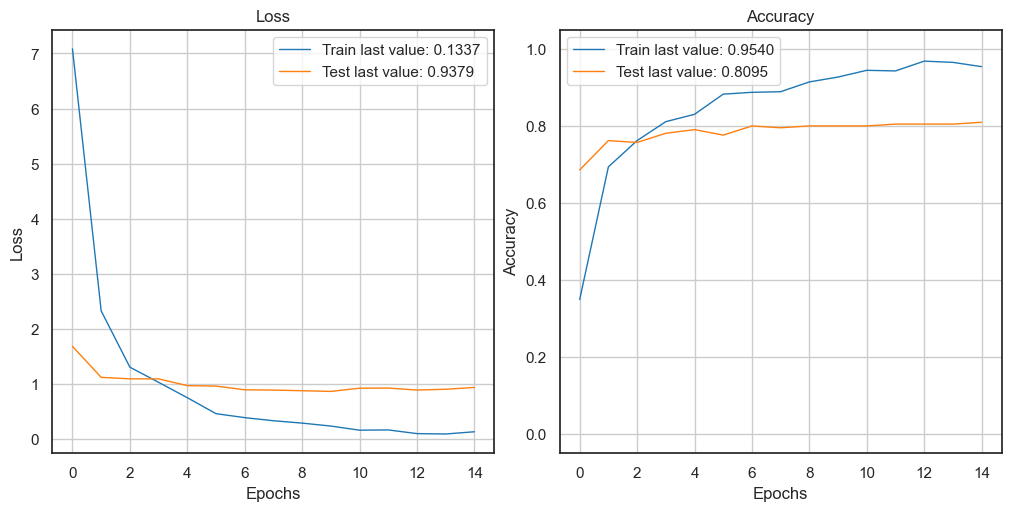

In [67]:
show_history(new_model1_info)
plot_history(new_model1_info)
plt.close()

<h4 style="font-family:Corbel Light; color:#737373">Classification Metrics - Test Set</h4>

In [68]:
Y_test_pred1 = np.argmax(new_model1.predict(X_test_preprocessed), axis=1)

7/7 [==============================] - 90s 12s/step


In [69]:
print('Classification Report :\n')
print(classification_report(Y_test_label, Y_test_pred1,
                            labels=np.unique(Y_test_label),
                            target_names=label_encoder1.inverse_transform(
                                np.unique(Y_test_label))
                            )
      )

Classification Report :

                            precision    recall  f1-score   support

                 Baby Care       0.86      0.60      0.71        30
  Beauty and Personal Care       0.88      0.73      0.80        30
                 Computers       0.76      0.93      0.84        30
Home Decor & Festive Needs       0.75      0.60      0.67        30
           Home Furnishing       0.77      0.90      0.83        30
          Kitchen & Dining       0.72      0.93      0.81        30
                   Watches       0.97      0.93      0.95        30

                  accuracy                           0.80       210
                 macro avg       0.81      0.80      0.80       210
              weighted avg       0.81      0.80      0.80       210



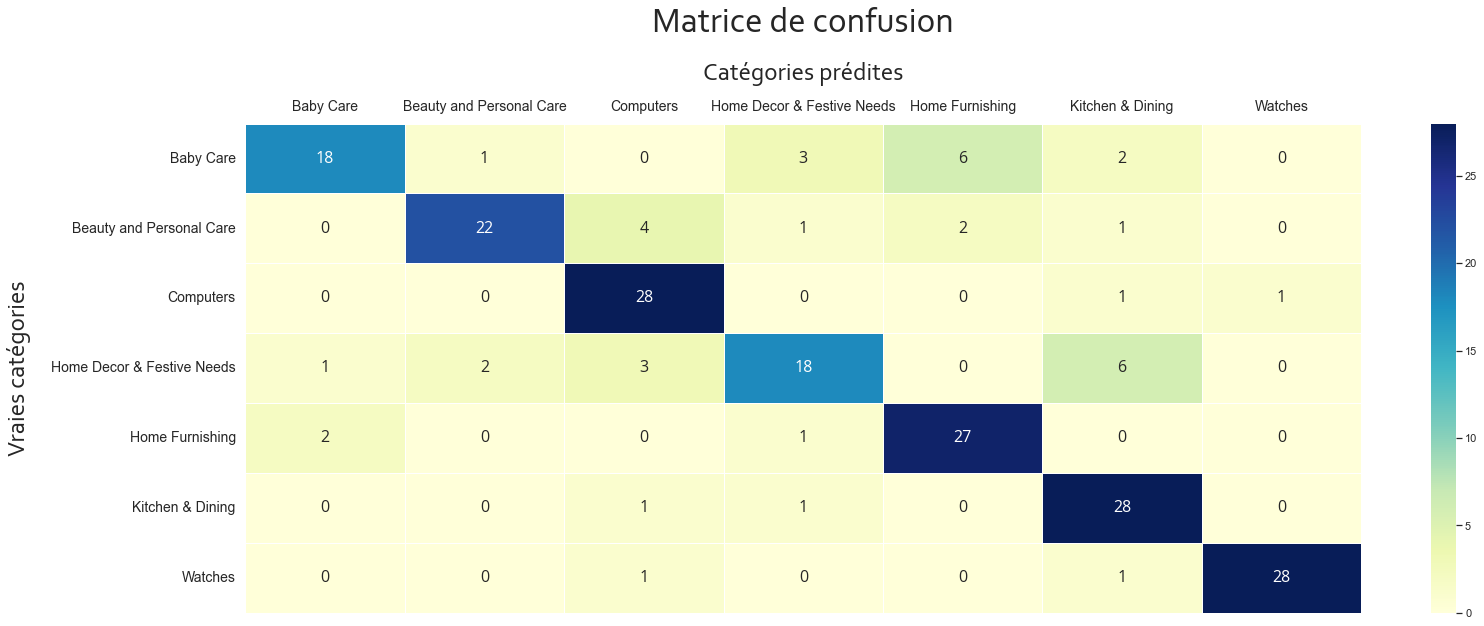

In [70]:
y_df = pd.DataFrame({'target': Y_test,
                     'label': Y_test_label,
                     'pred': Y_test_pred1})

toolbox.plot_confusion_matrix(y_df, (25, 9), add_label=False)

<h3 style="font-family:Corbel Light; color:#737373">Modèle VGG-16 - avec data augmentation</h3>

Pour limiter le surapprentissage nous allons utiliser une technique appelée "data augmentation" qui permet d'augmenter la diversité de notre ensemble d'entraînement. On va ajouter des images à notre jeu de données en leurs appliquant des transformations aléatoires mais réalistes (ex: rotation).

<h4 style="font-family:Corbel Light; color:#737373">Pré-traitement des images</h4>

Récupérons une image de l'ensemble de données et utilisons-la pour tester différentes transformations et voir leur résultat.

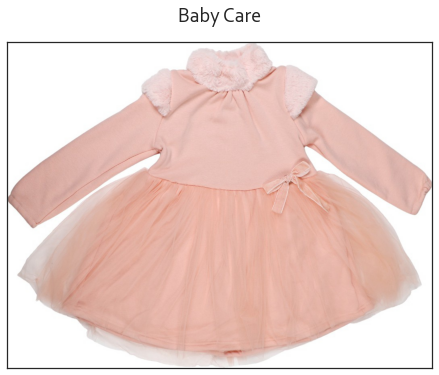

In [43]:
idx = randint(0, X_train.shape[0] + 1)
img_name = X_train.iloc[idx]
target = Y_train.iloc[idx]

toolbox.display_image_from_url(img_path + img_name, target, (12, 6))

In [44]:
image = cv2.imread(img_path + img_name, 3)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(813, 1060, 3)

Utilisons les calques de prétraitement Keras pour : 
- redimensionner cette image (avec tf.keras.layers.Resizing )
- redimensionner les valeurs de pixel (avec tf.keras.layers.Rescaling )

In [45]:
IMG_SIZE = 224

resize_and_rescale = Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),
    layers.Rescaling(1./255)
])

result = resize_and_rescale(image)

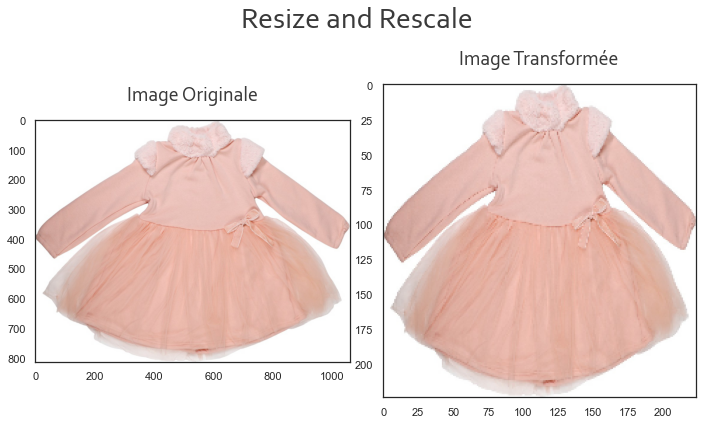

In [46]:
toolbox.display_image_transformation(image,
                                     result,
                                     'Resize and Rescale',
                                     (10, 6), top=0.8,
                                     axis_off=False)

Vérifions que les pixels sont dans la plage [0,1]

In [47]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.21826777 1.0


**CE1 Vous avez utilisé plusieurs techniques d’augmentation des données (ex. pour des images : rotation, changement d’échelle, ajout de bruit…).**

Utilisons les couches de prétraitement Keras pour générer de nouvelles images :

- en retournant l'image originale aléatoirement (avec RandomFlip)
- en inclinant l'image d'un angle aléatoire entre -10% * 2pi et 10% * 2pi, i.e. d'un angle maximum de 36° dans le sens des aiguilles d'une montre ou dans le sens opposé (avec RandomRotation)
- en zoomant aléatoirement en avant ou en arrière dans l'intervalle [-10%, +10%] (avec RandomZoom)

rmq: ces méthodes remplissent l'espace vide avec le reflet de l'image. Cet espace vide apparait suite à un zoom arrière ou
lorsque l'image doit être agrandie pour pouvoir afficher tous les pixels qui se trouvent en dehors des bornes initiales suite à une rotation. 

In [48]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
], name='data_augmentation')


# Mettons l'image dans une collection
image_batch = tf.expand_dims(result, 0)

In [49]:
image_batch.shape

TensorShape([1, 224, 224, 3])

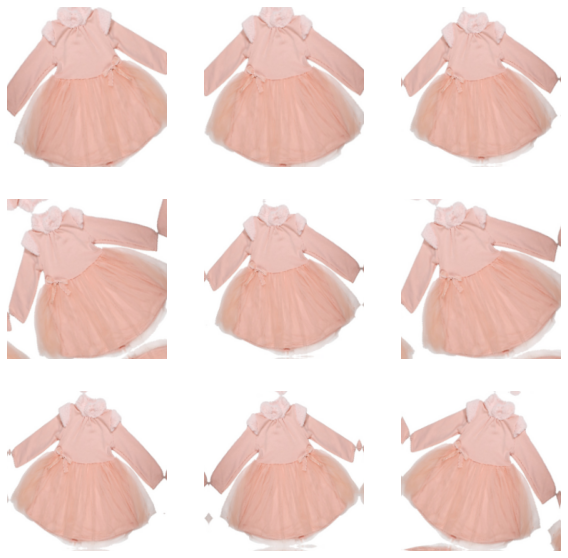

In [50]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image_batch)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy())
    plt.axis("off")

Intégrons ces couches de prétraitement au modèle vgg16.

<h4 style="font-family:Corbel Light; color:#737373">Transfer Learning</h4>

In [53]:
new_model2 = build_model(vgg16,
                         "categorical_crossentropy",
                         True,
                         name='vgg16_with_data_augmentation')

In [54]:
new_model2.summary()

Model: "vgg16_with_data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 7)

In [62]:
model2_save_path = "./model2_best_weights.h5"
model2_callbacks_list = toolbox.build_callbacks(model2_save_path)

In [ ]:
%%time
new_model2_info = new_model2.fit(x_train, y_train,
                                 validation_data=(x_val, y_val),
                                 batch_size=64, epochs=50, 
                                 callbacks=model2_callbacks_list, verbose=1)

<h4 style="font-family:Corbel Light; color:#737373">Historique</h4>

L'utilisation de la technique de data augmentation semble avoir réduit notre problème de surapprentissage

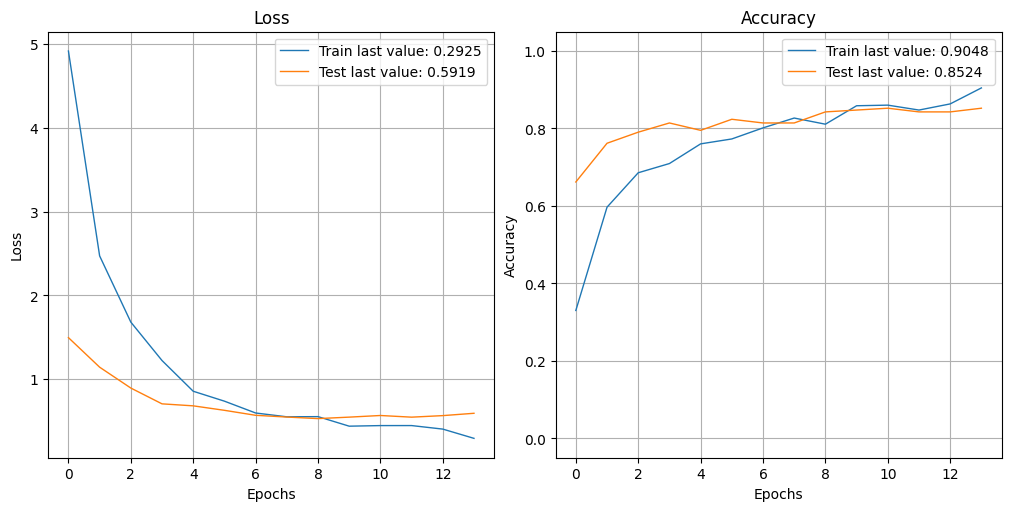

In [192]:
show_history(new_model2_info)
plot_history(new_model2_info)
plt.close()

<h4 style="font-family:Corbel Light; color:#737373">Classification Metrics - Test Set</h4>

Cependant la performance du modèle semble moins bonne.

In [77]:
Y_test_pred2 = np.argmax(new_model2.predict(X_test_preprocessed), axis=1)

7/7 [==============================] - 119s 16s/step


In [209]:
print('Classification Report :')
print(classification_report(Y_test_label, Y_test_pred2, 
                      labels = np.unique(Y_test_label),
                      target_names=label_encoder1.inverse_transform(np.unique(Y_test_label))
                     )
     )

Classification Report :

                            precision    recall  f1-score   support

                 Baby Care       0.57      0.67      0.62        30
  Beauty and Personal Care       0.88      0.77      0.82        30
                 Computers       0.87      0.87      0.87        30
Home Decor & Festive Needs       0.69      0.67      0.68        30
           Home Furnishing       0.71      0.73      0.72        30
          Kitchen & Dining       0.85      0.77      0.81        30
                   Watches       0.88      0.93      0.90        30

                  accuracy                           0.77       210
                 macro avg       0.78      0.77      0.77       210
              weighted avg       0.78      0.77      0.77       210



In [128]:
print('Classification Report : (modèle sans data augmentation) \n')
print(classification_report(Y_test_label, Y_test_pred1, 
                      labels = np.unique(Y_test_label),
                      target_names=label_encoder1.inverse_transform(np.unique(Y_test_label))
                     )
     )

Classification Report : (modèle sans data augmentation) 

                            precision    recall  f1-score   support

                 Baby Care       0.86      0.60      0.71        30
  Beauty and Personal Care       0.88      0.73      0.80        30
                 Computers       0.76      0.93      0.84        30
Home Decor & Festive Needs       0.75      0.60      0.67        30
           Home Furnishing       0.77      0.90      0.83        30
          Kitchen & Dining       0.72      0.93      0.81        30
                   Watches       0.97      0.93      0.95        30

                  accuracy                           0.80       210
                 macro avg       0.81      0.80      0.80       210
              weighted avg       0.81      0.80      0.80       210



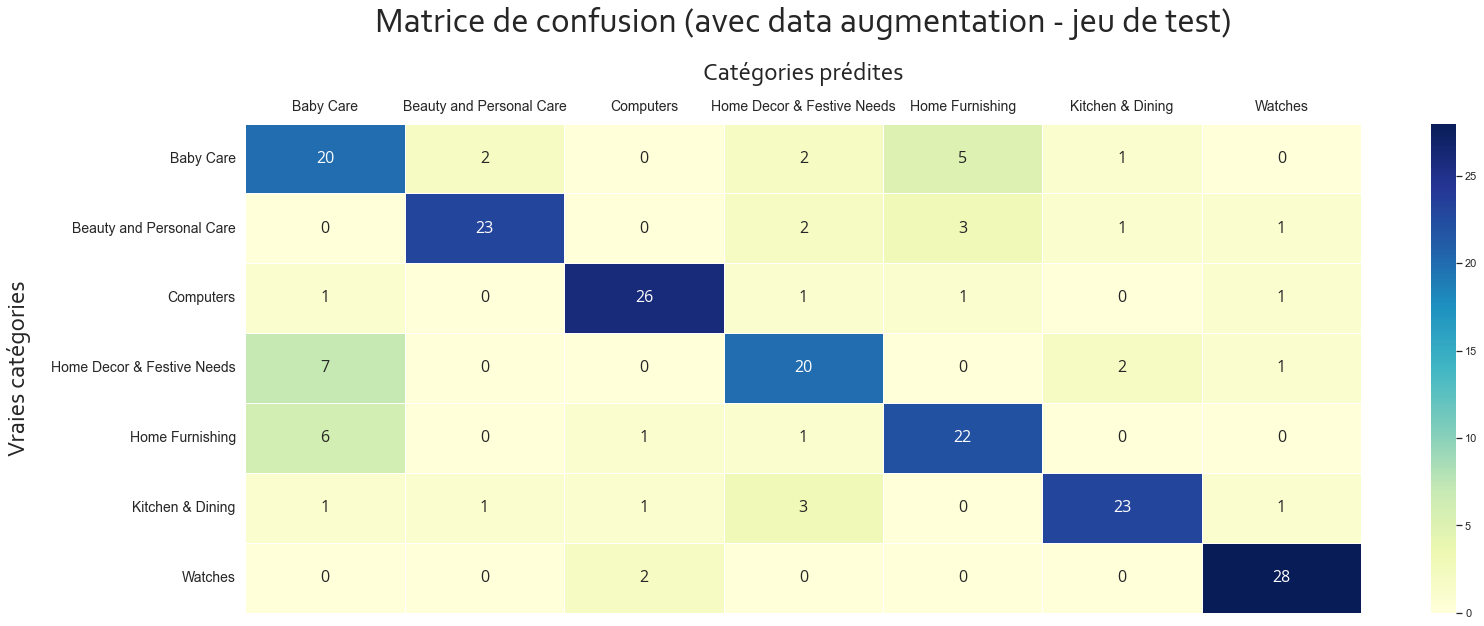

In [127]:
y2_opt_df = pd.DataFrame({'target': Y_test, 'label': Y_test_label, 'pred':Y_test_pred2_opt})
toolbox.plot_confusion_matrix(y2_opt_df, (25, 9), add_label=False, title=' (avec data augmentation - jeu de test)')

<h3 style="font-family:Corbel Light; color:#737373">Optimisation hyperparamètres</h3>

**CE5 : Vous avez optimisé au moins un des hyperparamètres du modèle choisi (par exemple : le choix de la fonction Loss, le Batch Size, le nombre d'Epochs)**

Regardons si l'optimisation des hyperparamètres suivants permet d'améliorer la performance du modèle avec data augmentation  :
- batch size
- fonction de perte
- nombre d'epochs

In [55]:
# fonction à minimiser
def cnn_accuracy_cv(params, base_model, datasets: dict, random_state=8, cv=5):
    callbacks = toolbox.build_callbacks("./model2_optimization.h5")

    model = build_model(base_model, params['loss'])

    start = perf_counter()

    result = model.fit(datasets['x_train'], datasets['y_train'],
                       validation_data=(datasets['x_val'], datasets['y_val']),
                       verbose=1,
                       batch_size=params['batch_size'],
                       epochs=params['epochs'],
                       callbacks=callbacks
                       )
    run_time = perf_counter() - start

    validation_loss = np.amin(result.history['val_loss'])

    return {'loss': validation_loss, 'params': params, 'train_time': run_time, 'status': STATUS_OK, 'model': model}

In [123]:
space = {'loss': hp.choice('loss', ["categorical_crossentropy", "kl_divergence"]),
         'batch_size': hp.choice('batch_size', [8, 16, 32, 64]),
         "epochs": scope.int(hp.quniform('epochs', 10, 50, 1))
         }

datasets = {'x_train': x_train, 'y_train': y_train,
            'x_val': x_val, 'y_val': y_val}

trials = Trials()
best_params = fmin(fn=partial(cnn_accuracy_cv, base_model=vgg16, datasets=datasets),
                   space=space,
                   algo=tpe.suggest,
                   max_evals=5,
                   trials=trials,
                   rstate=np.random.default_rng(8),
                   )

Epoch 1/17                                           

20/20 [==============================] - ETA: 0s - loss: 4.6577 - accuracy: 0.3810 
                                                     
Epoch 1: val_loss improved from inf to 2.17108, saving model to .\model2_optimization.h5

20/20 [==============================] - 727s 37s/step - loss: 4.6577 - accuracy: 0.3810 - val_loss: 2.1711 - val_accuracy: 0.7048

Epoch 2/17                                           

20/20 [==============================] - ETA: 0s - loss: 1.6426 - accuracy: 0.6651 
                                                     
Epoch 2: val_loss improved from 2.17108 to 1.47178, saving model to .\model2_optimization.h5

20/20 [==============================] - 412s 21s/step - loss: 1.6426 - accuracy: 0.6651 - val_loss: 1.4718 - val_accuracy: 0.7524

Epoch 3/17                                           

20/20 [==============================] - ETA: 0s - loss: 1.1827 - accuracy: 0.7254 
                           

In [126]:
trials_df = toolbox.build_trial_df(trials, 'validation_loss')
trials_df.head()

,batch_size,epochs,loss,validation_loss,trial_number
0,2.00,17.00,0.00,1.17,0
1,1.00,34.00,1.00,1.20,1
2,2.00,48.00,0.00,1.15,2
3,2.00,24.00,0.00,1.15,3
4,1.00,38.00,1.00,1.12,4


Après optimisation les meilleurs hyperparamètres semblent être :
- epochs = 38
- batch_size = 16
- loss = 'kl_divergence'

Cependant l'entrainement du modèle reste très long

In [160]:
best = trials.results[np.argmin([r['loss'] for r in trials.results])]
best_model = best['model']
best_params = best['params']
best_params

{'batch_size': 16, 'epochs': 38, 'loss': 'kl_divergence'}

In [142]:
print('Temps d\'entrainement du modèle :',
      str(timedelta(seconds=best['train_time']))
      )

Temps d'entrainement du modèle : 2:00:55.007362


Regardons les scores sur le jeu de test :

In [85]:
Y_test_pred2_opt = np.argmax(best_model.predict(X_test_preprocessed), axis=1)

7/7 [==============================] - 115s 16s/step


Le f1-score s'est amélioré pour la plupart des catégories par rapport au modèle sans data augmentation ni optimisation. Pour 2 catégories ("Watches" et "Home Furnishing") il a très légèrement diminué. 

In [144]:
print('Classification Report après optimisation:\n')
print(classification_report(Y_test_label, Y_test_pred2_opt, 
                      labels = np.unique(Y_test_label),
                      target_names=label_encoder1.inverse_transform(np.unique(Y_test_label))
                     )
     )

Classification Report après optimisation:

                            precision    recall  f1-score   support

                 Baby Care       0.78      0.70      0.74        30
  Beauty and Personal Care       0.92      0.80      0.86        30
                 Computers       0.81      0.87      0.84        30
Home Decor & Festive Needs       0.81      0.70      0.75        30
           Home Furnishing       0.75      0.90      0.82        30
          Kitchen & Dining       0.86      0.83      0.85        30
                   Watches       0.88      1.00      0.94        30

                  accuracy                           0.83       210
                 macro avg       0.83      0.83      0.83       210
              weighted avg       0.83      0.83      0.83       210



In [129]:
print('Classification Report : sans optimisation ni data augmentation \n')
print(classification_report(Y_test_label, Y_test_pred1, 
                      labels = np.unique(Y_test_label),
                      target_names=label_encoder1.inverse_transform(np.unique(Y_test_label))
                     )
     )

Classification Report : sans optimisation ni data augmentation 

                            precision    recall  f1-score   support

                 Baby Care       0.86      0.60      0.71        30
  Beauty and Personal Care       0.88      0.73      0.80        30
                 Computers       0.76      0.93      0.84        30
Home Decor & Festive Needs       0.75      0.60      0.67        30
           Home Furnishing       0.77      0.90      0.83        30
          Kitchen & Dining       0.72      0.93      0.81        30
                   Watches       0.97      0.93      0.95        30

                  accuracy                           0.80       210
                 macro avg       0.81      0.80      0.80       210
              weighted avg       0.81      0.80      0.80       210



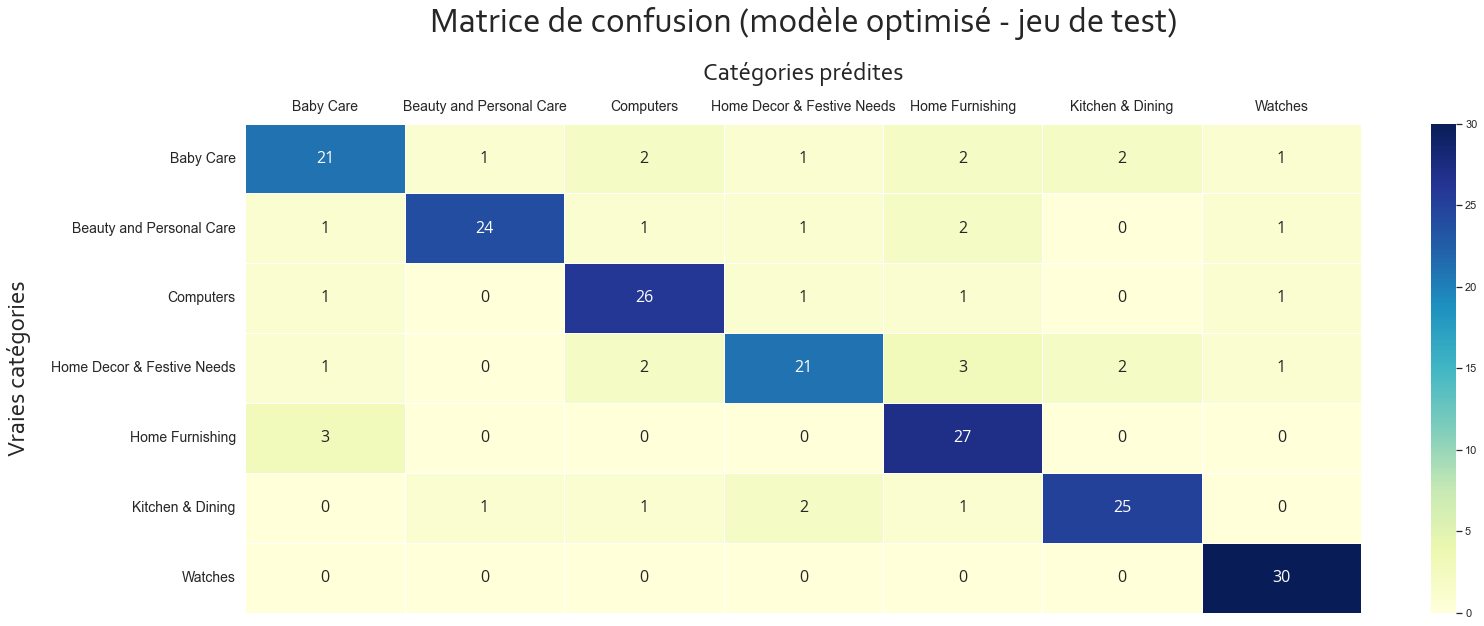

In [123]:
y2_opt_df = pd.DataFrame({'target': Y_test, 'label': Y_test_label, 'pred':Y_test_pred2_opt})
toolbox.plot_confusion_matrix(y2_opt_df, (25, 9), add_label=False, title=' (modèle optimisé - jeu de test)')

<h3 style="font-family:Corbel Light; color:#737373">Conclusion</h3>

- La technique de data augmentation nous a permis de réduire le problème de surapprentissage
- L'optimisation de quelques hyperparamètres nous a permis d'améliorer la performance du modèle